In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# All function

In [2]:
# function 
# show one example
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))


# Deal with data

In [6]:
# Data transform (normalize and data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.Resize((256,256)),
                         tt.RandomRotation(10),
                         tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize((256, 256)), tt.Normalize(*stats)])

In [7]:
# load data stucture (one folder per class)
dataset = ImageFolder('train', transform=tt.ToTensor())

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 852, 480]) 0


tensor([[[0.1059, 0.1059, 0.1059,  ..., 0.0235, 0.0039, 0.0000],
         [0.1059, 0.1059, 0.1059,  ..., 0.0235, 0.0000, 0.0000],
         [0.1098, 0.1098, 0.1098,  ..., 0.0353, 0.0118, 0.0000],
         ...,
         [0.2431, 0.2392, 0.2392,  ..., 0.2549, 0.2667, 0.2745],
         [0.2392, 0.2353, 0.2353,  ..., 0.2392, 0.2510, 0.2588],
         [0.2353, 0.2353, 0.2353,  ..., 0.2353, 0.2431, 0.2510]],

        [[0.1686, 0.1686, 0.1686,  ..., 0.0745, 0.0549, 0.0471],
         [0.1686, 0.1686, 0.1686,  ..., 0.0745, 0.0510, 0.0392],
         [0.1725, 0.1725, 0.1725,  ..., 0.0863, 0.0627, 0.0471],
         ...,
         [0.3804, 0.3765, 0.3725,  ..., 0.3608, 0.3765, 0.3843],
         [0.3765, 0.3725, 0.3686,  ..., 0.3451, 0.3608, 0.3686],
         [0.3725, 0.3725, 0.3686,  ..., 0.3412, 0.3529, 0.3608]],

        [[0.0275, 0.0275, 0.0275,  ..., 0.0353, 0.0157, 0.0078],
         [0.0275, 0.0275, 0.0275,  ..., 0.0353, 0.0118, 0.0000],
         [0.0314, 0.0314, 0.0314,  ..., 0.0471, 0.0235, 0.

Label:  0 (0)


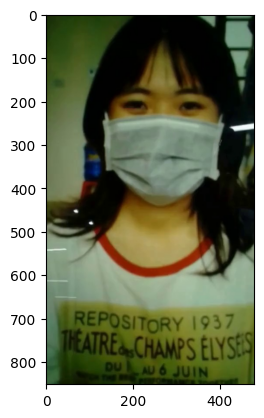

In [9]:
show_example(*dataset[0])

In [10]:
# Random split
train_set_size = int(len(dataset) * 0.8)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size])

In [11]:
batch_size = 128
# PyTorch data loaders
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_set, batch_size*2, num_workers=3, pin_memory=True)

In [12]:
# transform data
train_dl.dataset.dataset.transform = train_tfms
valid_dl.dataset.dataset.transform = valid_tfms

# Using GPU

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model Resnet-18

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class ResNet9(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=False, num_classes=2)
        
    def forward(self, xb):
        out = self.model(xb)
        return out

In [22]:
model = to_device(ResNet9(num_classes=2), device)
model

/home/duy1332002/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/duy1332002/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet9(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

# Save Model

In [23]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/best_model.pth')

In [24]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/final_model.pth')

# Training model

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    # initialize SaveBestModel class
    save_best_model = SaveBestModel()
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        #save best model
        save_best_model(train_losses[-1], epoch, model, optimizer, loss)
    
    # save final model
    save_model(epochs, model, optimizer, loss)
    return history

In [26]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [28]:
%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
Epoch [0], last_lr: 0.00050, train_loss: 0.3466, val_loss: 1.6905, val_acc: 0.6241

Best validation loss: 0.24400854110717773

Saving best model for epoch: 1

Epoch [1], last_lr: 0.00081, train_loss: 0.1885, val_loss: 0.1624, val_acc: 0.9330
Epoch [2], last_lr: 0.00130, train_loss: 0.1950, val_loss: 0.3304, val_acc: 0.8682

Best validation loss: 0.21749477088451385

Saving best model for epoch: 3

Epoch [3], last_lr: 0.00197, train_loss: 0.2314, val_loss: 0.3396, val_acc: 0.8736

Best validation loss: 0.1676514744758606

Saving best model for epoch: 4

Epoch [4], last_lr: 0.00279, train_loss: 0.2132, val_loss: 3.2200, val_acc: 0.5268
Epoch [5], last_lr: 0.00370, train_loss: 0.2306, val_loss: 0.9065, val_acc: 0.6553

Best validation loss: 0.15645144879817963

Saving best model for epoch: 6

Epoch [6], last_lr: 0.00468, train_loss: 0.2070, val_loss: 0.7460, val_acc: 0.7459
Epoch [7], last_lr: 0.00569, train_loss: 0.2342, val_

# plotting

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

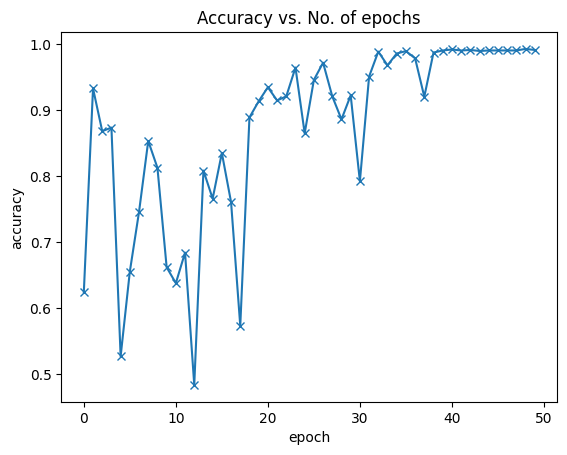

In [30]:
plot_accuracies(history)

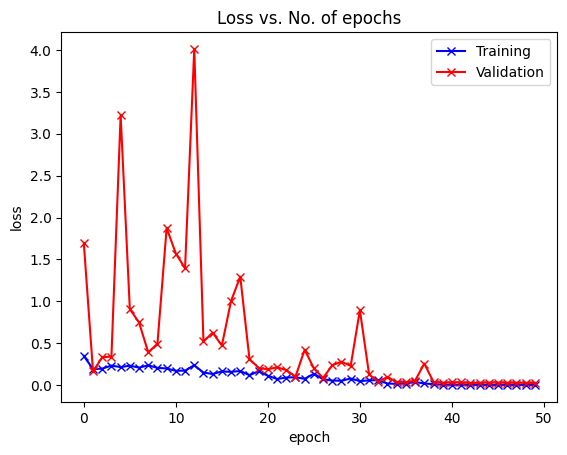

In [32]:
plot_losses(history)

In [33]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


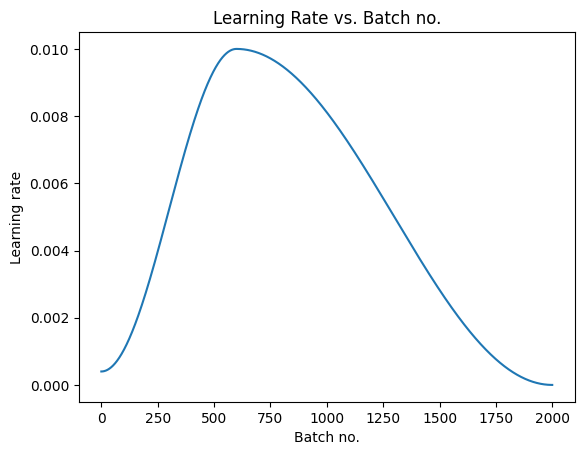

In [34]:
plot_lrs(history)

# Test with test

In [52]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [54]:
import cv2
import copy
from collections import Counter

def extractImages(pathIn):
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    result = []
    count = 0
    try:
        while success:
            vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))    # added this line 
            success, image = vidcap.read()

            image_copy = copy.deepcopy(image) 
            #image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
            # transform image to tensor
            image = valid_tfms(image_copy)
            # predict image
            pred = predict_image(image, model)
            result.append(pred)
            count += 1
    except:
        # get predict from result
        result = Counter(result)
        result = result.most_common(1)[0][0]
        return result

In [55]:
# list file in folder
list_file = os.listdir('public/videos/')
for i in list_file:
    # get path file
    path_file = os.path.join('public/videos/', i)
    # extract image from video
    result = extractImages(path_file)
    # save result to file
    print(i + " - " + result)
    with open('result.txt', 'a') as f:
        f.write(i + ' ' + result + "\n")

677.mp4 - 1
49.mp4 - 0
202.mp4 - 1
1116.mp4 - 0
1747.mp4 - 1
450.mp4 - 0
1600.mp4 - 0
1429.mp4 - 1
507.mp4 - 1
740.mp4 - 0
1332.mp4 - 1
705.mp4 - 0
1187.mp4 - 1
1519.mp4 - 1
841.mp4 - 0
123.mp4 - 0
1525.mp4 - 0
1276.mp4 - 1
672.mp4 - 0
1451.mp4 - 0
381.mp4 - 0
60.mp4 - 1
786.mp4 - 0
1678.mp4 - 1
832.mp4 - 0
867.mp4 - 1
186.mp4 - 1
1442.mp4 - 1
234.mp4 - 0
569.mp4 - 1
616.mp4 - 1
1631.mp4 - 0
342.mp4 - 1
1023.mp4 - 1
592.mp4 - 1
1440.mp4 - 0
1548.mp4 - 0
1214.mp4 - 1
1327.mp4 - 0
722.mp4 - 1
496.mp4 - 1
1439.mp4 - 0
479.mp4 - 0
1506.mp4 - 1
1847.mp4 - 0
648.mp4 - 0
1836.mp4 - 1
731.mp4 - 1
206.mp4 - 0
132.mp4 - 1
482.mp4 - 1
1745.mp4 - 0
1092.mp4 - 1
1239.mp4 - 1
1287.mp4 - 1
0.mp4 - 0
1045.mp4 - 0
790.mp4 - 1
1878.mp4 - 0
1634.mp4 - 0
1885.mp4 - 0
1258.mp4 - 0
1122.mp4 - 0
892.mp4 - 0
1005.mp4 - 1
1062.mp4 - 1
64.mp4 - 1
953.mp4 - 0
1022.mp4 - 0
1819.mp4 - 0
1495.mp4 - 0
1462.mp4 - 1
1638.mp4 - 0
214.mp4 - 1
537.mp4 - 0
1405.mp4 - 1
1686.mp4 - 0
410.mp4 - 1
527.mp4 - 1
1178.mp4 - 1
156